# Data visualization for the different parks separately

In the process of data preprocessing, the bolded out points below is the focus of this notebook.

Plan:

- Transform data
    - Pretend current wind predictions are measurements
    - Split into a measurement dataframe (enc_df) and a forecasting df (dec_df)
    - Transform degrees into cos and sin values

- Divide into parks, and for each park:
    - Overview over NaN values and how to deal with them
    - **Autocorrelation over wind speed, wind direction, production**
    - **How much does the wind speed and wind direction change when the forecast is updated?**

- Look at data for all parks
    - Normalize data for all parks (max production at each park is 1)
    - Look at correlations between production at the different parks
    - Look at correlations again, this time after splitting the data into wind direction quadrant

The data used for this visualization is the data where the missing values are filled. The visualization will be repeated at the end or in a new notebook, in order to see whether some of the qualitative observations change due to this difference.

<AxesSubplot:xlabel='time'>

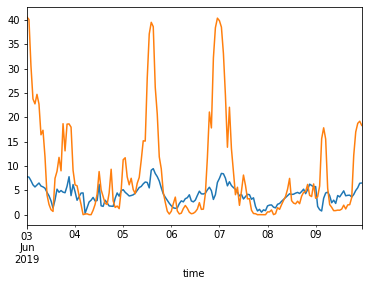

In [45]:
enc_df.loc['2019-06-03 00:00:00':'2019-06-09 23:00:00'].wind_speed_bess.plot()
enc_df.loc['2019-06-03 00:00:00':'2019-06-09 23:00:00'].production_bess.plot()

In [83]:
sin = enc_df.loc['2019-06-03 00:00:00':'2019-06-09 23:00:00'].wind_direction_sin_bess.values
cos = enc_df.loc['2019-06-03 00:00:00':'2019-06-09 23:00:00'].wind_direction_cos_bess.values

In [85]:
len(cos)/24

7.0

In [109]:
direction = cloud_direction(sin, cos)

In [110]:
def sin_transform(values):
        return np.sin(2*np.pi*values/360)

def cos_transform(values):
    return np.cos(2*np.pi*values/360)

In [111]:
X, Y = np.meshgrid(np.arange(len(cos)/7), np.arange(len(sin)/24))
#Y = np.zeros(len(sin))
U = cos_transform(direction)
V = sin_transform(direction)

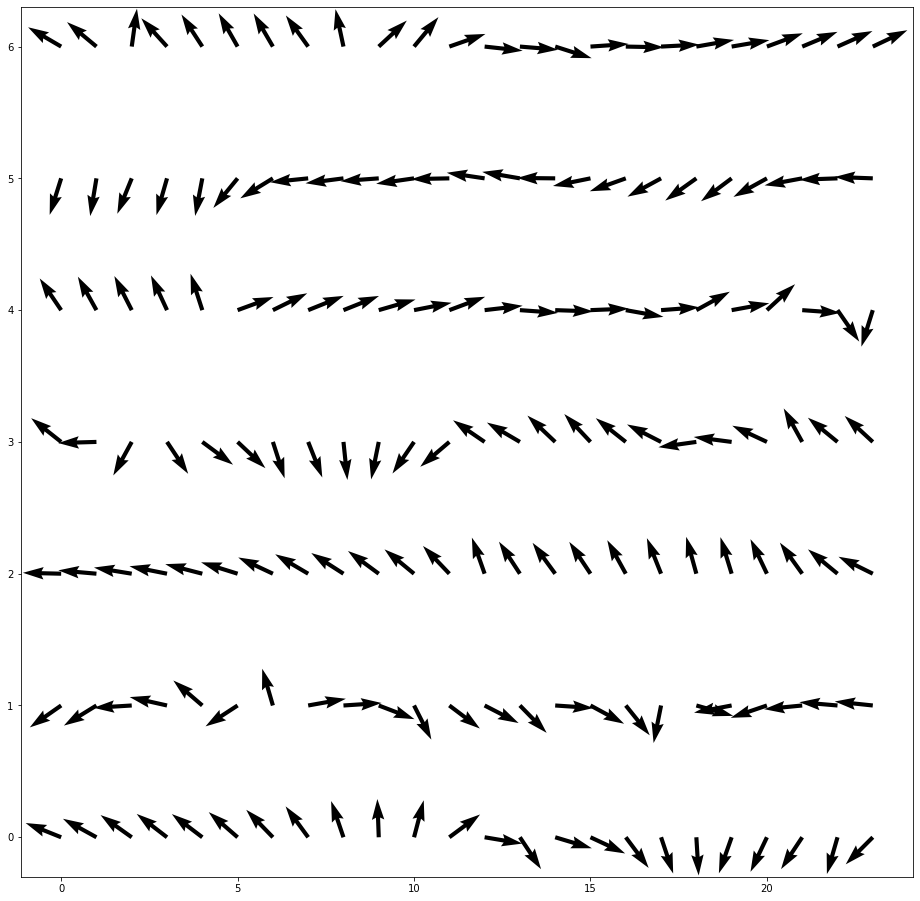

In [112]:
plt.figure(figsize=(16,16))
plt.quiver(X, Y, U, V)

In [113]:
cos

array([-0.37238172, -0.48332822, -0.57966417, -0.61009334, -0.60607572,
       -0.6566409 , -0.718076  , -0.8073955 , -0.94647841, -0.9993291 ,
       -0.96730236, -0.59575385,  0.16534861,  0.83314984,  0.28779536,
        0.42321386,  0.80150487,  0.94852981,  0.99815946,  0.94280193,
        0.90300505,  0.83288596,  0.96087072,  0.70708738,  0.57275753,
        0.52529033,  0.06093743, -0.21941876, -0.65295442,  0.54573098,
       -0.96026821, -0.17594204, -0.0653622 ,  0.35775824,  0.89178818,
        0.60217568,  0.45911504,  0.71514955,  0.06683171,  0.47698088,
        0.77951495,  0.98075149,  0.27228465,  0.18759064,  0.32207527,
        0.09733466, -0.08538882, -0.10471956, -0.02359568, -0.0877764 ,
       -0.16130242, -0.19499982, -0.24979764, -0.29736793, -0.42464213,
       -0.50807521, -0.53999553, -0.59385043, -0.63570661, -0.72466711,
       -0.94293768, -0.83697587, -0.80684913, -0.83205816, -0.87542455,
       -0.92885751, -0.96387253, -0.95596705, -0.90279362, -0.81

In [66]:
def degrees(sin, cos):
    deg = np.zeros(len(sin))
    for i in range(len(sin)):
        if cos[i]>0:
            deg[i] = np.arcsin(sin[i])*180/np.pi
            if deg[i] < 0:
                deg[i] += 360
        elif sin[i]>0:
            deg[i] = np.arccos(cos[i])*180/np.pi
        else:
            deg[i] = np.arctan(sin[i]/cos[i])*180/np.pi+180
    return deg

In [108]:
def cloud_direction(sin, cos):
    return (degrees(cos, sin)+180) % 360

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import src.satprod.pipelines.data_handler as dh

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, acf, pacf, plot_pacf

In [5]:
pd.set_option("display.max_rows", 700, "display.max_columns", 50)

In [6]:
# get data
root = '..'
path = f'{root}/data/formatted'

enc_df, dec_df = dh.read_formatted_data_no_nan(path)

# the no nan data is not available for the test set times, so there is nothing to remove
#split = datetime(2020, 5, 1, 0)
#enc_df = enc_df[enc_df.index < split]
#dec_df = dec_df[dec_df.index < split]

In [14]:
dev_mode = True # to not have to scroll over all the plots when coding

## Utility functions

In [15]:
def wind_speed_plots(park: str):
    #acf_wind = acf(enc_df[f'wind_speed_{park}'].dropna(axis=0).values, nlags=24*14, fft=False)
    
    fig = plot_acf(enc_df[f'wind_speed_{park}'].dropna(axis=0).values, lags=24*400)
    plt.xlabel('hours')
    plt.show()
    
    fig = plot_acf(enc_df[f'wind_speed_{park}'].dropna(axis=0).values, lags=24*4)
    plt.xlabel('hours')
    plt.show()
    
    fig = plot_pacf(enc_df[f'wind_speed_{park}'].dropna(axis=0), lags=24*7)
    plt.xlabel('hours')
    plt.show()
    
def wind_speed_forecast_change(park: str):
    ch_wind = (dec_df[f'wind_speed_{park}+1h'].shift()-enc_df[f'wind_speed_{park}'])
    
    # remove all rows where there was no update in the forecasts, and use absolute values
    ch_wind = ch_wind[np.abs(ch_wind) > 1e-6]
    
    plt.figure(figsize=(16,4))
    ch_wind.plot()
    plt.title('Wind speed forecast change when updated')
    plt.show()
    
    print(f'Mean forecast change when updated: {np.mean(ch_wind)}.')
    
    plt.figure(figsize=(16,4))
    np.abs(ch_wind).plot()
    plt.title('Wind speed forecast absolute change when updated')
    plt.show()
    
    print(f'Mean forecast absolute change when updated: {np.mean(np.abs(ch_wind))}.')

def wind_direction_plots(park: str):
    plot_acf(enc_df[f'wind_direction_sin_{park}'].dropna(axis=0).values, lags=24*10)
    plt.title('Autocorrelation, wind direction sine')
    plt.xlabel('hours')
    plt.show()
    plot_acf(enc_df[f'wind_direction_cos_{park}'].dropna(axis=0).values, lags=24*10)
    plt.title('Autocorrelation, wind direction cosine')
    plt.xlabel('hours')
    plt.show()

    plot_pacf(enc_df[f'wind_direction_sin_{park}'].dropna(axis=0).values, lags=24*10)
    plt.title('Partial autocorrelation, wind direction sine')
    plt.xlabel('hours')
    plt.show()
    plot_pacf(enc_df[f'wind_direction_cos_{park}'].dropna(axis=0).values, lags=24*10)
    plt.title('Partial autocorrelation, wind direction cosine')
    plt.xlabel('hours')
    plt.show()
    
def wind_direction_forecast_change(park: str):
    ch_dir_sin = (dec_df[f'wind_direction_sin_{park}+1h'].shift()-enc_df[f'wind_direction_sin_{park}'])
    ch_dir_cos = (dec_df[f'wind_direction_cos_{park}+1h'].shift()-enc_df[f'wind_direction_cos_{park}'])

    # remove all rows where there was no update in the forecasts, and use absolute values
    ch_dir_sin = ch_dir_sin[np.abs(ch_dir_sin) > 1e-6]
    ch_dir_cos = ch_dir_cos[np.abs(ch_dir_cos) > 1e-6]

    plt.figure(figsize=(16,4))
    ch_dir_sin.plot()
    plt.title('Wind direction sine forecast change when updated')
    plt.show()

    plt.figure(figsize=(16,4))
    ch_dir_cos.plot()
    plt.title('Wind direction cosine forecast change when updated')
    plt.show()

    print(f'Mean sine forecast change when updated: {np.mean(ch_dir_sin)}.')
    print(f'Mean cosine forecast change when updated: {np.mean(ch_dir_cos)}.')

    plt.figure(figsize=(16,4))
    np.abs(ch_dir_sin).plot()
    plt.title('Wind direction sine forecast absolute change when updated')
    plt.show()

    plt.figure(figsize=(16,4))
    np.abs(ch_dir_cos).plot()
    plt.title('Wind direction cosine forecast absolute change when updated')
    plt.show()

    print(f'Mean sine forecast absolute change when updated: {np.mean(np.abs(ch_dir_sin))}.')
    print(f'Mean cos forecast absolute change when updated: {np.mean(np.abs(ch_dir_cos))}.')
    
def production_plots(park: str):
    fig = plot_acf(enc_df[f'production_{park}'].dropna(axis=0).values, lags=24*400)
    plt.xlabel('hours')
    plt.show()

    fig = plot_acf(enc_df[f'production_{park}'].dropna(axis=0).values, lags=24*4)
    plt.xlabel('hours')
    plt.show()

    fig = plot_pacf(enc_df[f'production_{park}'].dropna(axis=0), lags=24*7)
    plt.xlabel('hours')
    plt.show()

## Bessaker

### Wind speed

In [16]:
if not dev_mode: wind_speed_plots('bess')

In [17]:
if not dev_mode: wind_speed_forecast_change('bess')

The forecasts are rarely corrected by more than $2$ m/s, and on average just $0.5$ m/s. 

### Wind direction

In [18]:
if not dev_mode: wind_direction_plots('bess')

In [19]:
if not dev_mode: wind_direction_forecast_change('bess')

### Production

In [20]:
if not dev_mode: production_plots('bess')

### Relation between wind speed, wind direction, and production

In [15]:
park = 'bess'

In [36]:
enc_df_park_cols = [col for col in enc_df.columns if park in col]
enc_df_park_cols = [ x for x in enc_df_park_cols if 'direction' not in x ]
dec_df_park_cols = [col for col in dec_df.columns if park in col]
dec_df_park_cols = [ x for x in dec_df_park_cols if 'direction' not in x ]

In [37]:
#df = pd.concat([enc_df[enc_df_park_cols], dec_df[dec_df_park_cols]], axis=1)

In [67]:
prod_shift_df = pd.DataFrame()
names = []
for i in range(-10, 10):
    new = enc_df[f'production_{park}'].shift(i)
    names.append(f'production_{park}_shift_{i}')
    prod_shift_df = pd.concat([prod_shift_df, new], axis=1)
prod_shift_df.columns = names

wind_shift_df = pd.DataFrame()#enc_df[f'wind_speed_{park}']#.shift(i)
names = []
for i in range(-10, 10):
    new = enc_df[f'wind_speed_{park}'].shift(i)
    names.append(f'wind_speed_{park}_shift_{i}')
    wind_shift_df = pd.concat([wind_shift_df, new], axis=1)
wind_shift_df.columns = names

combo = pd.concat([wind_shift_df, prod_shift_df], axis=1)
del wind_shift_df, prod_shift_df

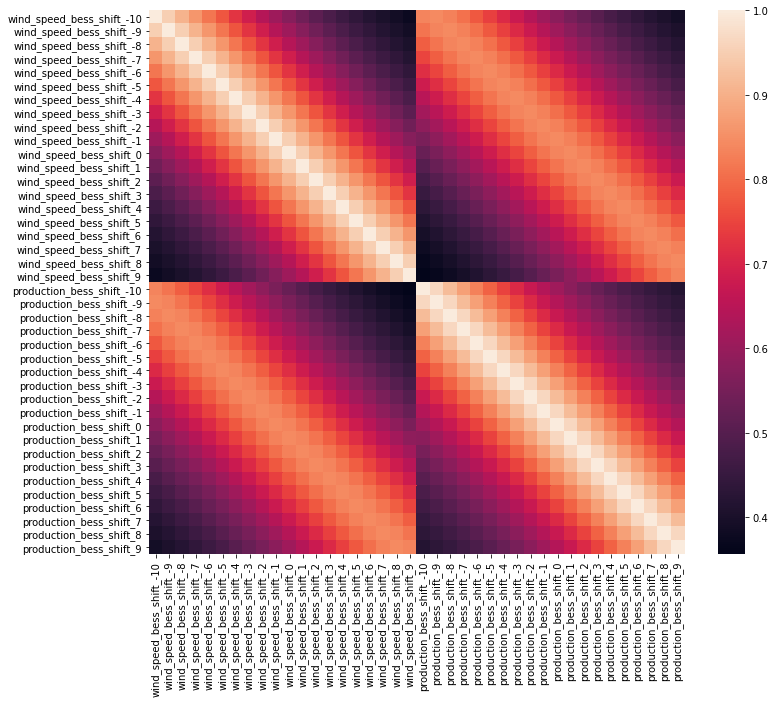

In [79]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(combo.corr(), ax=ax)
plt.show()

## Skomaker

### Wind speed

In [59]:
if not dev_mode: wind_speed_plots('skom')

In [ ]:
if not dev_mode: wind_forecast_change('skom')

### Wind direction

In [ ]:
if not dev_mode: wind_direction_plots('skom')

In [ ]:
if not dev_mode: wind_direction_forecast_change('skom')

### Production

In [ ]:
if not dev_mode: production_plots('skom')

### Relation between wind speed, wind direction, and production

## Valsneset

### Wind speed

In [60]:
if not dev_mode: wind_speed_plots('vals')

In [62]:
if not dev_mode: wind_speed_forecast_change('vals')

### Wind direction

In [ ]:
if not dev_mode: wind_direction_plots('vals')

In [ ]:
if not dev_mode: wind_direction_forecast_change('vals')

### Production

In [ ]:
if not dev_mode: production_plots('vals')

### Relation between wind speed, wind direction, and production

## Ytre vikna

### Wind speed

In [63]:
if not dev_mode: wind_speed_plots('yvik')

In [64]:
if not dev_mode: wind_speed_forecast_change('yvik')

### Wind direction

In [ ]:
if not dev_mode: wind_direction_plots('yvik')

In [ ]:
if not dev_mode: wind_direction_forecast_change('yvik')

### Production

In [ ]:
if not dev_mode: production_plots('yvik')

### Relation between wind speed, wind direction, and production

# Sneak peak all parks gathered

In [21]:
enc_df_prod_cols = [col for col in enc_df.columns if 'prod' in col]

In [22]:
prod = enc_df[enc_df_prod_cols]

In [23]:
from sklearn import preprocessing

x = prod.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
prod = pd.DataFrame(x_scaled, columns=enc_df_prod_cols)

In [24]:
prod

,production_bess,production_skom,production_vals,production_yvik
0,0.552054,0.812042,0.681584,0.256375
1,0.495943,0.655081,0.727733,0.449760
2,0.483929,0.574099,0.721187,0.627451
3,0.307166,0.406082,0.592558,0.628575
4,0.312196,0.444304,0.697178,0.955855
...,...,...,...,...
29179,0.499398,0.814736,0.275557,0.499956
29180,0.509686,0.835719,0.236486,0.352751
29181,0.532755,0.942115,0.267691,0.309459
29182,0.790080,0.960496,0.435345,0.290319


<AxesSubplot:>

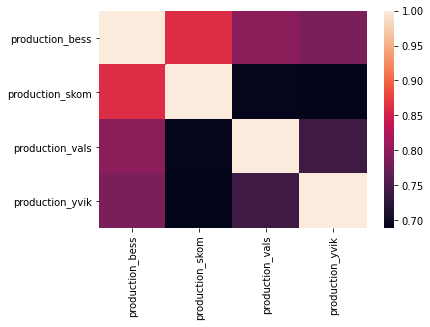

In [25]:
sns.heatmap(prod.corr())

In [26]:
prod_shift = pd.DataFrame()
names = []
for j in range(len(prod.columns)):
    for i in range(0, 5):
        new = prod[prod.columns[j]].shift(i)
        names.append(f'{prod.columns[j]}_shift_{i}')
        prod_shift = pd.concat([prod_shift, new], axis=1)
prod_shift.columns = names

In [27]:
#prod_shift = prod_shift.reindex(sorted(prod_shift.columns), axis=1)

In [28]:
prod_shift_bess_skom = [col for col in prod_shift.columns if 'bess' in col] + [
    col for col in prod_shift.columns if 'skom' in col]
prod_shift_bess_yvik = [col for col in prod_shift.columns if 'bess' in col] + [
    col for col in prod_shift.columns if 'yvik' in col]
prod_shift_bess_vals = [col for col in prod_shift.columns if 'bess' in col] + [
    col for col in prod_shift.columns if 'vals' in col]
prod_shift_yvik_vals = [col for col in prod_shift.columns if 'yvik' in col] + [
    col for col in prod_shift.columns if 'vals' in col]

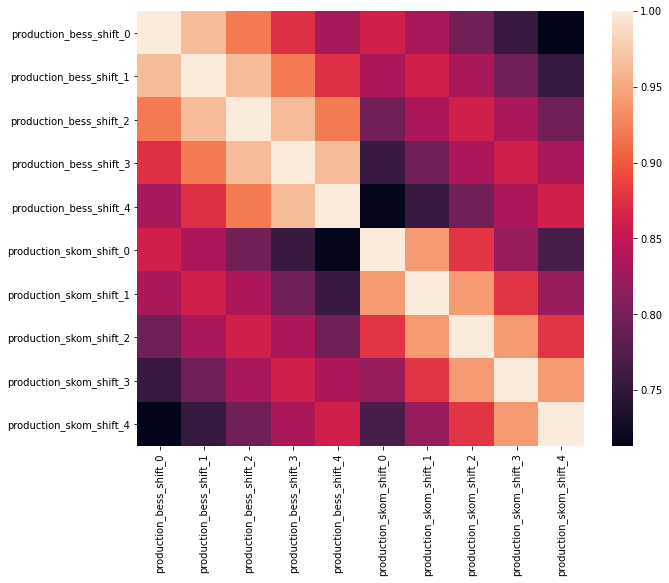

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(prod_shift[prod_shift_bess_skom].corr(), ax=ax)
plt.show()

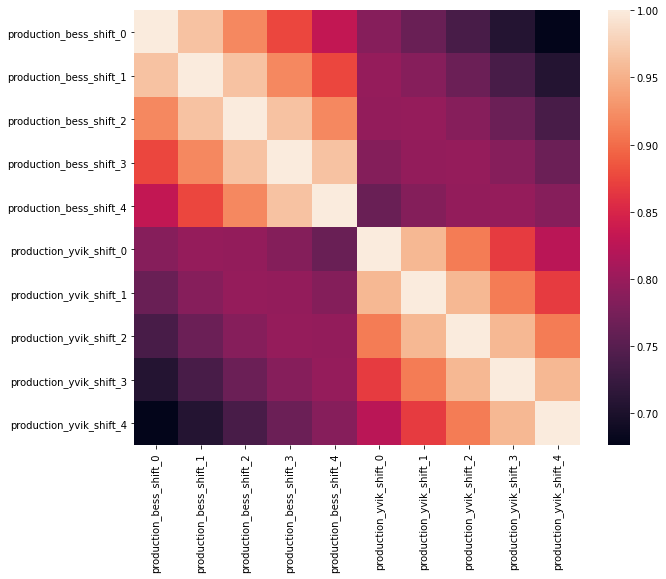

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(prod_shift[prod_shift_bess_yvik].corr(), ax=ax)
plt.show()

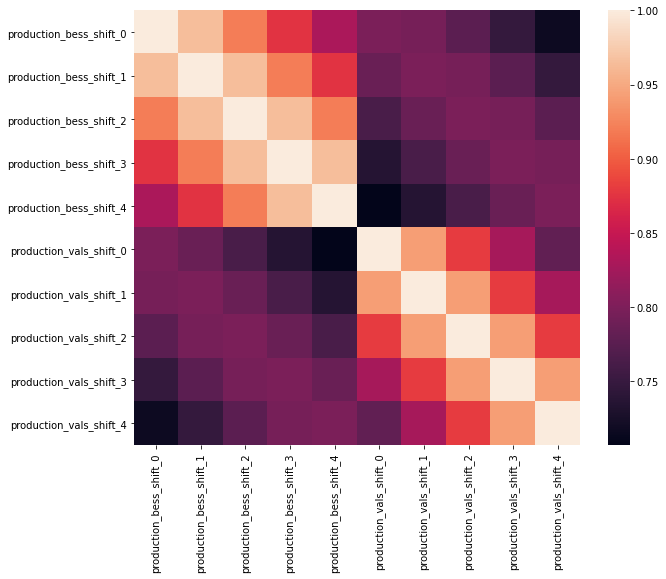

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(prod_shift[prod_shift_bess_vals].corr(), ax=ax)
plt.show()

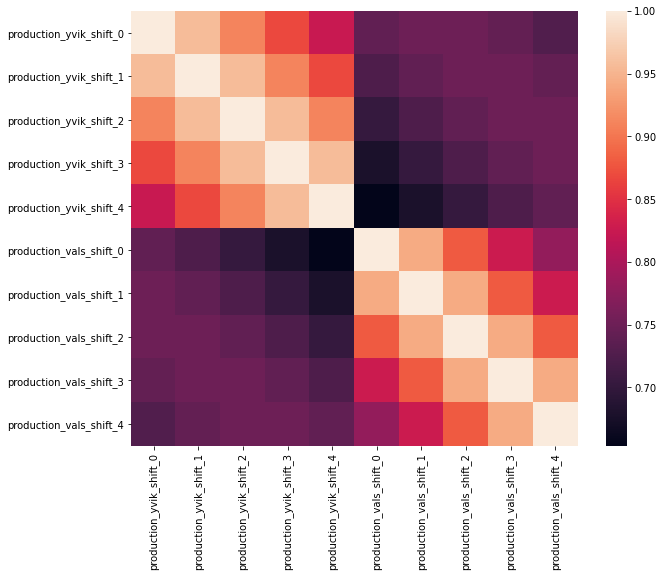

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(prod_shift[prod_shift_yvik_vals].corr(), ax=ax)
plt.show()

- Production at the different parks are very correlated
- Production at Yvik in lags -1, -2 is correlated to 0 at the other parks
- Production at Vals in lags 0, 1 is correlated to 0 at Bess and Skom
- Production at Vals in lags 1, 2 is correlated to 0 at Yvik

This means that Yvik "knows" that there is going to be a rise in production at Bess and Skom 1-2 hours in advance, and that the production at Bess and Skom gives the same information about Vals 0-1 hours before.

In [33]:
enc_df_wind_speed_cols = [col for col in enc_df.columns if 'wind_speed' in col]
wind = enc_df[enc_df_wind_speed_cols]

x = wind.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
wind = pd.DataFrame(x_scaled, columns=enc_df_wind_speed_cols)

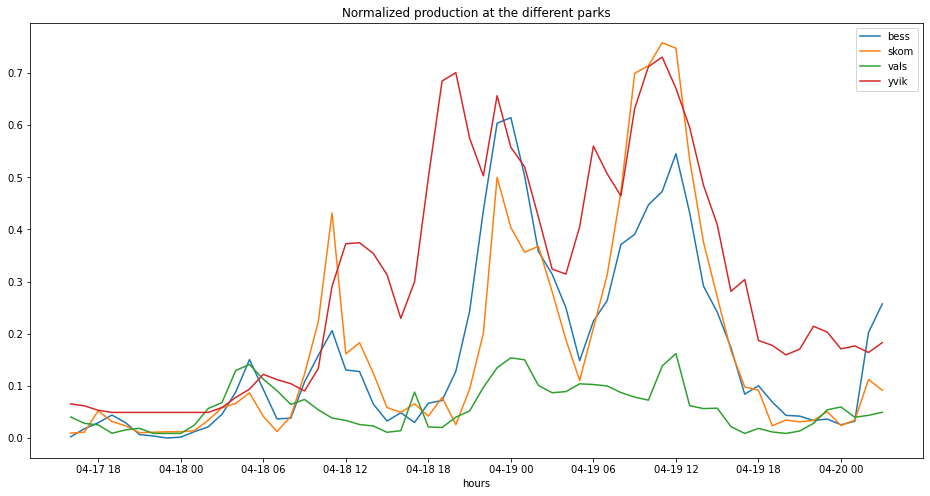

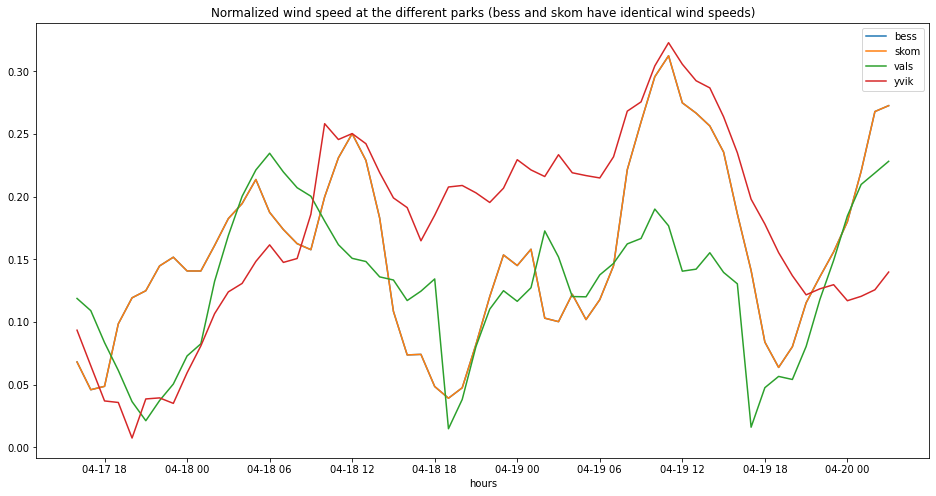

In [34]:
start, stop=20080, 20140
plt.figure(figsize=(16,8))
plt.plot(enc_df.iloc[start:stop].index, prod.production_bess.values[start:stop], label='bess')
plt.plot(enc_df.iloc[start:stop].index, prod.production_skom.values[start:stop], label='skom')
plt.plot(enc_df.iloc[start:stop].index, prod.production_vals.values[start:stop], label='vals')
plt.plot(enc_df.iloc[start:stop].index, prod.production_yvik.values[start:stop], label='yvik')
plt.legend()
plt.title('Normalized production at the different parks')
plt.xlabel('hours')
plt.show()

plt.figure(figsize=(16,8))
plt.plot(enc_df.iloc[start:stop].index, wind.wind_speed_bess.values[start:stop], label='bess')
plt.plot(enc_df.iloc[start:stop].index, wind.wind_speed_skom.values[start:stop], label='skom')
plt.plot(enc_df.iloc[start:stop].index, wind.wind_speed_vals.values[start:stop], label='vals')
plt.plot(enc_df.iloc[start:stop].index, wind.wind_speed_yvik.values[start:stop], label='yvik')
plt.legend()
plt.title('Normalized wind speed at the different parks (bess and skom have identical wind speeds)')
plt.xlabel('hours')
plt.show()

In [35]:
wind.corr()

,wind_speed_bess,wind_speed_skom,wind_speed_vals,wind_speed_yvik
wind_speed_bess,1.000000,1.000000,0.801308,0.771722
wind_speed_skom,1.000000,1.000000,0.801308,0.771722
wind_speed_vals,0.801308,0.801308,1.000000,0.757460
wind_speed_yvik,0.771722,0.771722,0.757460,1.000000


Images from 2019-04-18 08:00:00 to 2019-04-18 11:00:00. The wave of clouds along the west coast of Norway shows a wind coming from the south-west, which is also somewhat observable from the wind speed plot above, showing a peak for wind at Valsneset before a peak for the three other parks.

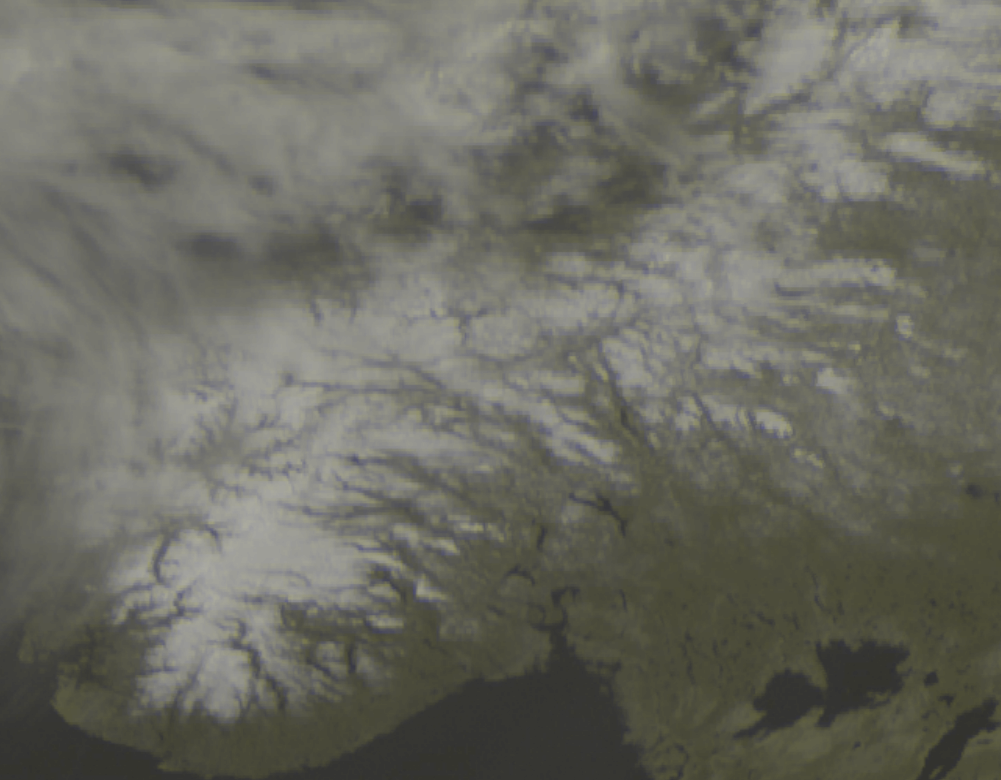

In [177]:
sat1.pilImage

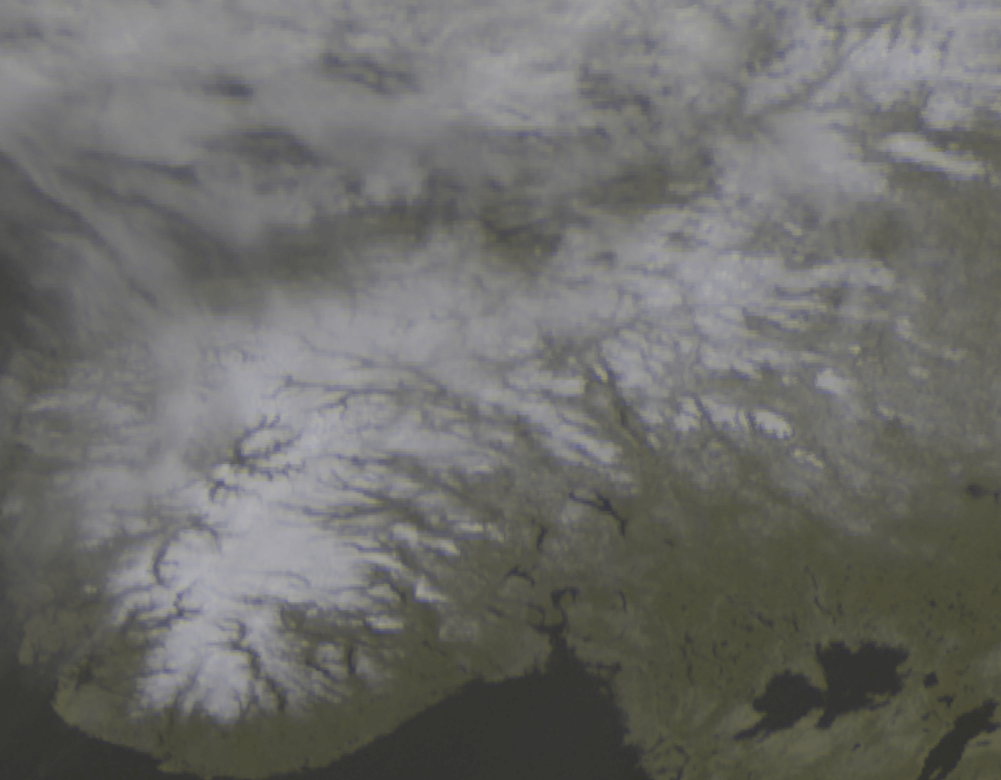

In [178]:
sat2.pilImage

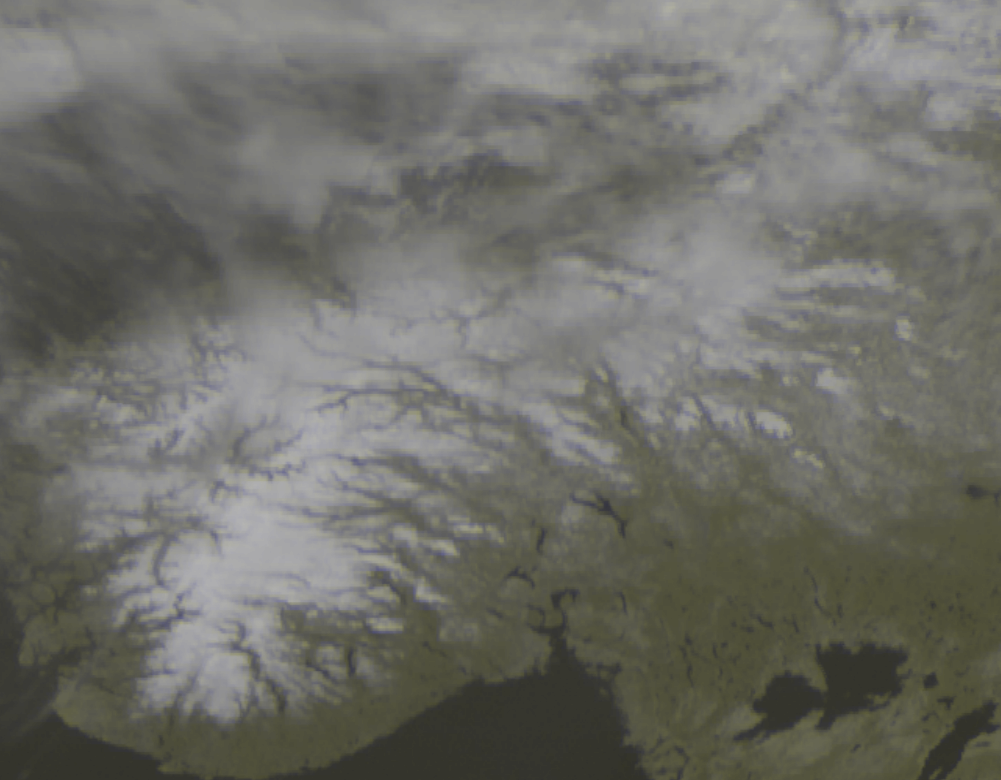

In [180]:
sat3.pilImage

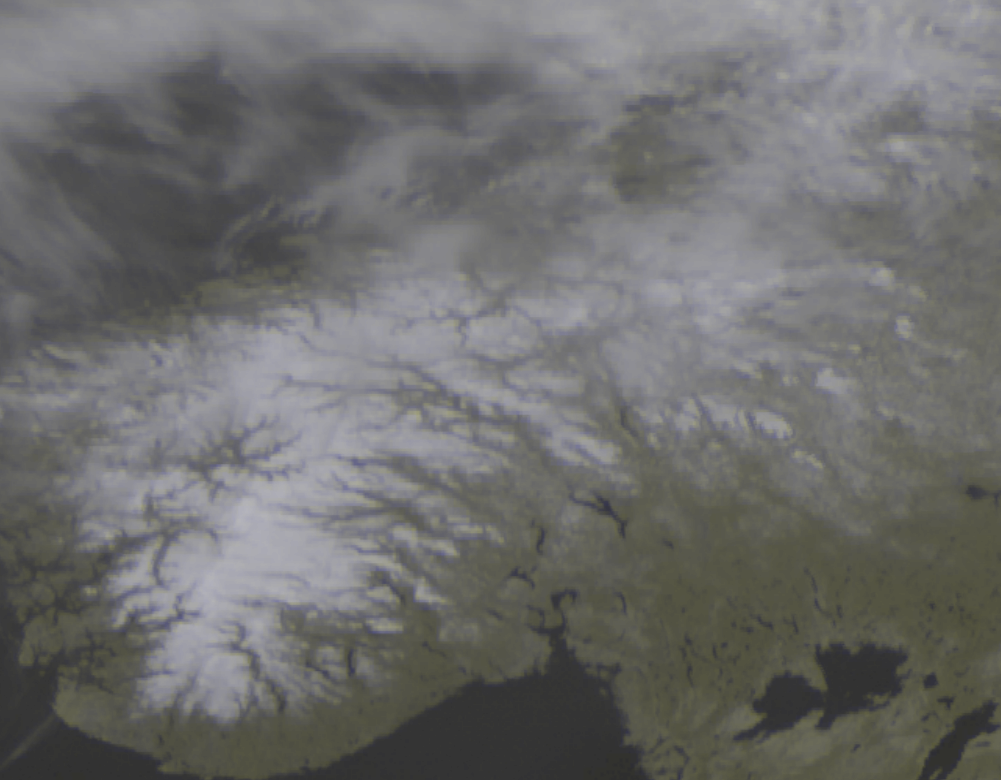

In [181]:
sat4.pilImage

In [36]:
import torch
import torchvision
from torchvision import transforms
from datetime import datetime, timedelta
import os
import numpy as np
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt

In [37]:
def path2datetime(path: str) -> datetime:
    '''Takes string of the form "2018/03/20/00;00;00.png" and 
    converts it to the corresponding date in datetime format.
    
    Inputs of the form "/2018/03/20/00;00;00.png", is also handled'''
    if path[0]=='/':
        path = path[1:]
        
    assert path[-4:]=='.png', 'The path has to end with ".png"'
    return datetime.strptime(path[:-4], '%Y/%m/%d/%H;%M;%S')

def datetime2path(datetime: datetime) -> str:
    '''Takes a datetime and converts it to the 
    corresponding path in string format'''
    
    return datetime.strftime('%Y/%m/%d/%H;00;00.png')

'''Test'''
path='/2018/03/20/00;00;00.png'
print(path2datetime(path))
print(datetime2path(path2datetime(path)))

2018-03-20 00:00:00
2018/03/20/00;00;00.png


In [38]:
%%capture

class SatImg():
    '''
    One satellite image, as a PIL image and a tensor. 
    The date and time of the image is also included.
    '''
    
    def __init__(self, 
                 pilImage, 
                 date: datetime):
        
        self.toTensor = transforms.ToTensor()
        self.pilImage = pilImage.convert('RGB')
        self.date = date
        self.tensor = self.toTensor(self.pilImage)
    
    def getImgChannel(self, channel: int):
        return self.pilImage.getchannel(channel)
    
    def getTensorChannel(self, channel: int):
        return self.toTensor(self.getImgChannel(channel))
    
    def displayTensor(self):
        plt.imshow(self.tensor.permute(1, 2, 0))
        plt.show()

class SatImgDataset(torch.utils.data.Dataset):
    '''
    Set of all the satellite images, including 
    information on the time they were taken.
    '''
    
    def __init__(self, root: str):
        self.root = root
        
        self.img_paths = []
        for img in torchvision.datasets.ImageFolder(self.root).imgs:
            self.img_paths.append(img[0])
        
        self.timestamps = [path2datetime(self.img_paths[i][len(self.root):]) for i in range(len(self.img_paths))]

    def __getitem__(self, idx: int):
        img = Image.open(self.img_paths[idx])
        date = self.timestamps[idx]
        return SatImg(img, date)

    def __len__(self):
        return len(self.img_paths)
    
    def getDateIdx(self, date: datetime) -> int:
        return self.timestamps.index(date)

In [39]:
imgpath = f'{root}/data/img'
data = SatImgDataset(imgpath)

In [40]:
date1 = datetime(2019, 4, 18, 8, 0)
sat1 = data[data.getDateIdx(date1)]
date2 = date1+timedelta(hours=1)
sat2 = data[data.getDateIdx(date2)]
date3 = date2+timedelta(hours=1)
sat3 = data[data.getDateIdx(date3)]
date4 = date3+timedelta(hours=1)
sat4 = data[data.getDateIdx(date4)]